## Imports:

In [1]:
import scipy
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plt_lab
import matplotlib.gridspec as gridspec
import obspy
import pandas as pd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load data:
We are going to use this data to plot spectograms of SCG signals. 

In [3]:
dir_path = "/Users/ecem/Documents/GitHub/seismocardiogram/data/diseased-dataset"

In [4]:
h_x = np.load(dir_path + "/healty_x.npy", allow_pickle= True)
h_y = np.load(dir_path + "/healty_z.npy", allow_pickle= True)
h_z = np.load(dir_path + "/healty_y.npy", allow_pickle= True)

In [5]:
d_x = np.load(dir_path + "/diseased_x.npy", allow_pickle= True)
d_y = np.load(dir_path + "/diseased_z.npy", allow_pickle= True)
d_z = np.load(dir_path + "/diseased_y.npy", allow_pickle= True)

## comparison of two dataset:

Now we will to try visualize spectograms. So far we have used Obspy to visualize SCG signals. However, with obspy we are not able to plot spectograms side by side. This is important for us because we want to see spectograms of x,y and z components simultaneously for both healty and diseased people. So, from now on I will refer to those plots, for 3 components of healty and diseased (in total six plot, as "PAIR").


I have mentioned that Obpsy has a problem in side by side plotting. So I changed it's source code. 

Thats why from now on we are going to use **output_spectogram** function to get the coefficients needed to plot spectogram.

These are the imports needed for output_spectogram function to work.

In [6]:
from obspy.imaging.cm import obspy_sequential
import math
from matplotlib import mlab
from matplotlib.colors import Normalize

In [7]:
def _nearest_pow_2(x):
    a = math.pow(2, math.ceil(np.log2(x)))
    b = math.pow(2, math.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

In [8]:
def output_spectrogram(data, samp_rate, per_lap=0.9, wlen=None, log=False,
                outfile=None, fmt=None, axes=None, dbscale=False,
                mult=8.0, cmap=obspy_sequential, zorder=None, title=None,
                show=True, clip=[0.0, 1.0]):
 
    import matplotlib.pyplot as plt
    
    # enforce float for samp_rate
    samp_rate = float(samp_rate)

    # set wlen from samp_rate if not specified otherwise
    if not wlen:
        wlen = samp_rate / 100.

    npts = len(data)
    # nfft needs to be an integer, otherwise a deprecation will be raised
    # XXX add condition for too many windows => calculation takes for ever
    nfft = int(_nearest_pow_2(wlen * samp_rate))
    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))

    if mult is not None:
        mult = int(_nearest_pow_2(mult))
        mult = mult * nfft
    nlap = int(nfft * float(per_lap))

    data = data - data.mean()
    end = npts / samp_rate

    # Here we call not plt.specgram as this already produces a plot
    # matplotlib.mlab.specgram should be faster as it computes only the
    # arrays
    # XXX mlab.specgram uses fft, would be better and faster use rfft
    specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
                                         pad_to=mult, noverlap=nlap)
    # db scale and remove zero/offset for amplitude
    if dbscale:
        specgram = 10 * np.log10(specgram[1:, :])
    else:
        specgram = np.sqrt(specgram[1:, :])
    freq = freq[1:]
    
    vmin, vmax = clip
    if vmin < 0 or vmax > 1 or vmin >= vmax:
        msg = "Invalid parameters for clip option."
        raise ValueError(msg)
    _range = float(specgram.max() - specgram.min())
    vmin = specgram.min() + vmin * _range
    vmax = specgram.min() + vmax * _range
    norm = Normalize(vmin, vmax, clip=True)

    # calculate half bin width
    halfbin_time = (time[1] - time[0]) / 2.0
    halfbin_freq = (freq[1] - freq[0]) / 2.0

    # argument None is not allowed for kwargs on matplotlib python 3.3
    kwargs = {k: v for k, v in (('cmap', cmap), ('zorder', zorder))
              if v is not None}

    if log:
        # pcolor expects one bin more at the right end
        freq = np.concatenate((freq, [freq[-1] + 2 * halfbin_freq]))
        time = np.concatenate((time, [time[-1] + 2 * halfbin_time]))
        # center bin
        time -= halfbin_time
        freq -= halfbin_freq
        # Log scaling for frequency values (y-axis)
        ax.set_yscale('log')
        # Plot times
        ax.pcolormesh(time, freq, specgram, norm=norm, **kwargs)
    else:
        # this method is much much faster!
        specgram = np.flipud(specgram)
        # center bin
        extent = (time[0] - halfbin_time, time[-1] + halfbin_time,
                  freq[0] - halfbin_freq, freq[-1] + halfbin_freq)
    return [specgram, extent, end]

    



specgram : array-like


        2D array, columns are the periodograms of successive segments.

In [9]:
for i in range(len(h_x)):
    delta = h_x[i].stats.delta
    st = h_x[i].stats.starttime
    h_x[i] = h_x[i].trim(st, st + 230 * delta)

In [10]:
healty = []
for i in range(len(h_x)):
    healty.append(output_spectrogram(h_x[i].data, h_x[i].stats.sampling_rate, wlen=10)[0])


In [11]:
healty = np.array(healty)

In [12]:
for i in range(len(d_x)):
    delta = d_x[i].stats.delta
    st = d_x[i].stats.starttime
    d_x[i] = d_x[i].trim(st, st + 230 * delta)

In [13]:
diseased = []
for i in range(len(d_x)):
    diseased.append(output_spectrogram(d_x[i].data, d_x[i].stats.sampling_rate, wlen=10)[0])

In [14]:
diseased = np.array(diseased)

## Mann Whitney u test

In [15]:
from scipy.stats import mannwhitneyu

In [16]:
mannwhitneyu(healty, diseased, use_continuity=False, alternative = 'two-sided')

MannwhitneyuResult(statistic=array([[1060., 1185., 1082., ...,  953.,  997., 1023.],
       [1057., 1177., 1091., ...,  960., 1002., 1046.],
       [1082., 1166., 1092., ...,  971., 1009., 1048.],
       ...,
       [ 994.,  982., 1049., ..., 1065., 1085., 1094.],
       [ 980.,  974., 1063., ..., 1067., 1081., 1099.],
       [ 967.,  962., 1068., ..., 1064., 1092., 1098.]]), pvalue=array([[0.56298096, 0.12140049, 0.45371986, ..., 0.80078551, 0.92885444,
        0.77093604],
       [0.57880752, 0.13706506, 0.41272704, ..., 0.84305876, 0.89806483,
        0.6385528 ],
       [0.45371986, 0.16109284, 0.40831183, ..., 0.9103649 , 0.85522609,
        0.62749815],
       ...,
       [0.94738247, 0.9783209 , 0.62200182, ..., 0.53707673, 0.43980653,
        0.39956626],
       [0.965939  , 0.92885444, 0.54736618, ..., 0.52688542, 0.45841223,
        0.3782008 ],
       [0.8857892 , 0.85522609, 0.52182704, ..., 0.54220928, 0.40831183,
        0.38241665]]))

In [19]:
mannwhitneyu(healty, diseased, use_continuity=False, alternative = 'two-sided')[0].shape

(128, 50)

In [20]:
mannwhitneyu(healty, diseased, use_continuity=False, alternative = 'two-sided')[1].shape

(128, 50)

In [25]:
df_stats = pd.DataFrame(mannwhitneyu(healty, diseased, use_continuity=False, alternative = 'two-sided')[0])
df_stats

0       1       2       3       4       5       6       7       8   \
0    1060.0  1185.0  1082.0   972.0   921.0  1053.0  1054.0  1060.0  1094.0   
1    1057.0  1177.0  1091.0   980.0   940.0  1040.0  1056.0  1068.0  1088.0   
2    1082.0  1166.0  1092.0   977.0   964.0  1019.0  1064.0  1071.0  1067.0   
3    1105.0  1165.0  1110.0   981.0   995.0  1025.0  1073.0  1064.0  1047.0   
4    1128.0  1159.0  1111.0  1005.0   993.0  1017.0  1092.0  1072.0  1024.0   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
123  1019.0   989.0  1031.0  1084.0  1153.0  1037.0  1009.0   996.0  1005.0   
124  1009.0   987.0  1043.0  1086.0  1119.0  1036.0  1011.0   993.0   994.0   
125   994.0   982.0  1049.0  1073.0  1102.0  1030.0  1011.0  1006.0   981.0   
126   980.0   974.0  1063.0  1057.0  1082.0  1017.0  1002.0   998.0   972.0   
127   967.0   962.0  1068.0  1044.0  1083.0  1008.0  1003.0  1003.0   976.0   

        9   ...     40      41      42      43      44      45      46  \
0    907.0  ...  966.0   912.0   877.0   832.0   869.0   963.0  1003.0   
1    937.0  ...  968.0   929.0   889.0   835.0   871.0   965.0  1006.0   
2    951.0  ...  971.0   952.0   892.0   828.0   870.0   951.0   975.0   
3    953.0  ...  979.0   978.0   909.0   825.0   855.0   932.0   966.0   
4    941.0  ...  994.0  1000.0   923.0   827.0   837.0   930.0   963.0   
..     ...  ...    ...     ...     ...     ...     ...     ...     ...   
123  981.0  ...  927.0  1072.0  1164.0  1190.0  1143.0  1132.0  1073.0   
124  962.0  ...  924.0  1073.0  1165.0  1176.0  1147.0  1111.0  1072.0   
125  943.0  ...  912.0  1077.0  1170.0  1170.0  1126.0  1095.0  1064.0   
126  925.0  ...  918.0  1078.0  1172.0  1162.0  1123.0  1092.0  1049.0   
127  917.0  ...  918.0  1102.0  1190.0  1175.0  1111.0  1088.0  1016.0   

         47      48      49  
0     953.0   997.0  1023.0  
1     960.0  1002.0  1046.0  
2     971.0  1009.0  1048.0  
3     977.0  1025.0  1049.0  
4    1007.0  1038.0  1046.0  
..      ...     ...     ...  
123  1092.0  1093.0  1061.0  
124  1082.0  1086.0  1078.0  
125  1065.0  1085.0  1094.0  
126  1067.0  1081.0  1099.0  
127  1064.0  1092.0  1098.0  

[128 rows x 50 columns]

In [28]:
df_p = pd.DataFrame(mannwhitneyu(healty, diseased, use_continuity=False, alternative = 'two-sided')[1])
df_p

0         1         2         3         4         5         6   \
0    0.562981  0.121400  0.453720  0.916523  0.616526  0.600229  0.594840   
1    0.578808  0.137065  0.412727  0.965939  0.723891  0.672194  0.584129   
2    0.453720  0.161093  0.408312  0.947382  0.867428  0.794791  0.542209   
3    0.353511  0.163426  0.333734  0.972129  0.941203  0.759088  0.496915   
4    0.268565  0.177962  0.329866  0.879661  0.953565  0.806792  0.408312   
..        ...       ...       ...       ...       ...       ...       ...   
123  0.794791  0.978321  0.723891  0.444417  0.193439  0.689269  0.855226   
124  0.855226  0.990708  0.655286  0.435224  0.299971  0.694997  0.843059   
125  0.947382  0.978321  0.622002  0.496915  0.365726  0.729719  0.843059   
126  0.965939  0.928854  0.547366  0.578808  0.453720  0.806792  0.898065   
127  0.885789  0.855226  0.521827  0.649688  0.449055  0.861323  0.891924   

           7         8         9   ...        40        41        42  \
0    0.562981  0.399566  0.542209  ...  0.879661  0.568233  0.399566   
1    0.521827  0.426141  0.706504  ...  0.891924  0.660903  0.453720   
2    0.506803  0.526885  0.788808  ...  0.910365  0.794791  0.467878   
3    0.542209  0.633015  0.800786  ...  0.959751  0.953565  0.552547   
4    0.501846  0.765005  0.729719  ...  0.947382  0.910365  0.627498   
..        ...       ...       ...  ...       ...       ...       ...   
123  0.935027  0.879661  0.972129  ...  0.649688  0.501846  0.165784   
124  0.953565  0.947382  0.855226  ...  0.633015  0.496915  0.163426   
125  0.873541  0.972129  0.741422  ...  0.568233  0.477451  0.152012   
126  0.922686  0.916523  0.638553  ...  0.600229  0.472651  0.147620   
127  0.891924  0.941203  0.594840  ...  0.600229  0.365726  0.112345   

           43        44        45        46        47        48        49  
0    0.233349  0.365726  0.861323  0.891924  0.800786  0.928854  0.770936  
1    0.242611  0.374014  0.873541  0.873541  0.843059  0.898065  0.638553  
2    0.221393  0.369855  0.788808  0.935027  0.910365  0.855226  0.627498  
3    0.212718  0.310962  0.677867  0.879661  0.947382  0.759088  0.622002  
4    0.218474  0.248928  0.666539  0.861323  0.867428  0.683559  0.638553  
..        ...       ...       ...       ...       ...       ...       ...  
123  0.112345  0.221393  0.255359  0.496915  0.408312  0.403925  0.557752  
124  0.139128  0.209882  0.329866  0.501846  0.453720  0.435224  0.472651  
125  0.152012  0.275341  0.395236  0.542209  0.537077  0.439807  0.399566  
126  0.170578  0.285722  0.408312  0.622002  0.526885  0.458412  0.378201  
127  0.141215  0.329866  0.426141  0.812810  0.542209  0.408312  0.382417  

[128 rows x 50 columns]

In [29]:
df_p.style.apply(lambda x: ["background: yellow" if v < 0.05 else "" for v in x], axis = 1)

<AxesSubplot:>

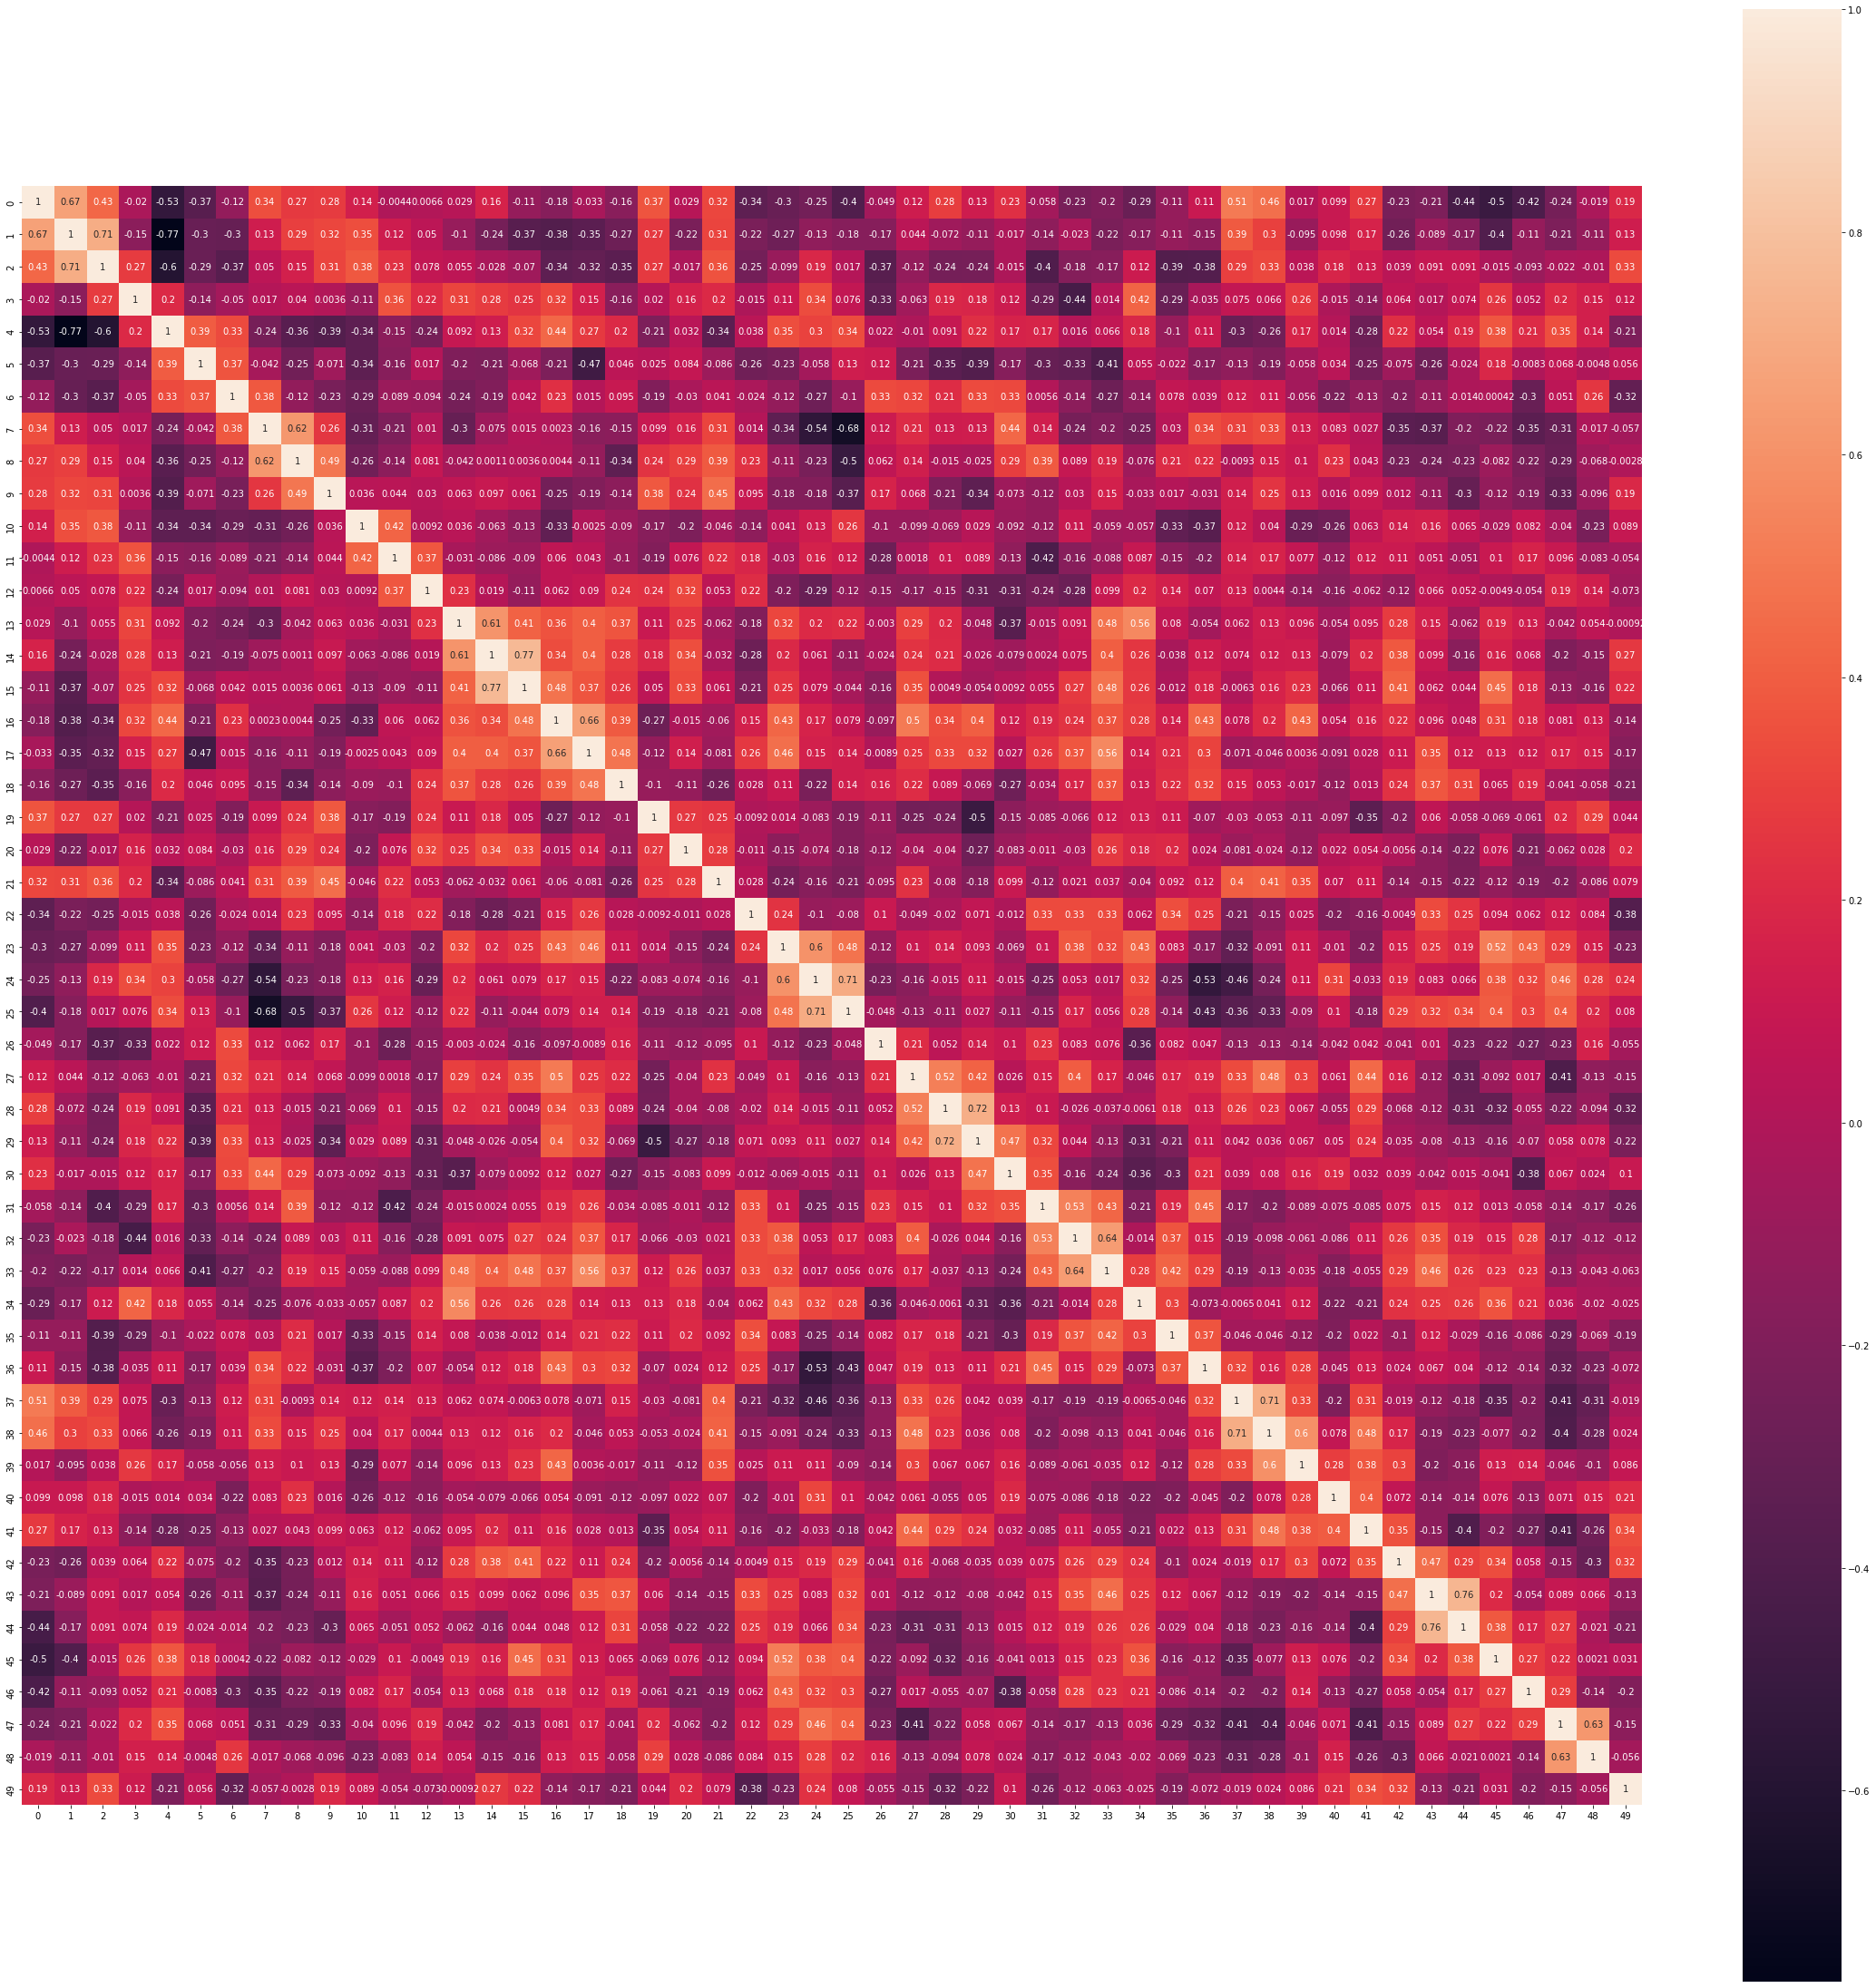

In [30]:
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(40,40)
sns.heatmap(df_p.corr(), square = True, annot = True)

## Two sample t test: 
iki grubun mean lerinin esit olup olmamasina bakmis olursun.

In [31]:
from scipy import stats

In [32]:
stats.ttest_ind(healty, diseased)

Ttest_indResult(statistic=array([[ 0.4310711 ,  1.2579007 ,  0.71453482, ...,  0.08354963,
         0.07115518, -0.24506377],
       [ 0.47027497,  1.23858947,  0.7313656 , ...,  0.08388394,
         0.07296857, -0.21415433],
       [ 0.57282999,  1.23384649,  0.78299833, ...,  0.06665301,
         0.08309959, -0.15773599],
       ...,
       [-0.18406771, -0.08530542,  0.43890573, ...,  0.37466092,
         0.5491236 ,  0.67305295],
       [-0.17726583, -0.08509606,  0.45583831, ...,  0.39526205,
         0.60639411,  0.75647221],
       [-0.16454672, -0.09936238,  0.47864686, ...,  0.39860231,
         0.65654508,  0.77287918]]), pvalue=array([[0.66736339, 0.21141668, 0.47659513, ..., 0.93358494, 0.94341926,
        0.80691949],
       [0.63920349, 0.21845618, 0.46630106, ..., 0.93331982, 0.94197985,
        0.83087166],
       [0.56807179, 0.220211  , 0.43551618, ..., 0.94699374, 0.93394186,
        0.87498939],
       ...,
       [0.85434068, 0.93219262, 0.661696  , ..., 0.70872218

In [33]:
statics = stats.ttest_ind(healty, diseased)[0]
statics.shape

(128, 50)

In [34]:
p_value = stats.ttest_ind(healty, diseased)[1]
p_value.shape

(128, 50)

In [35]:
p_val = pd.DataFrame(p_value)
p_val.style.apply(lambda x: ["background: yellow" if v < 0.05 else "" for v in x], axis = 1)

<AxesSubplot:>

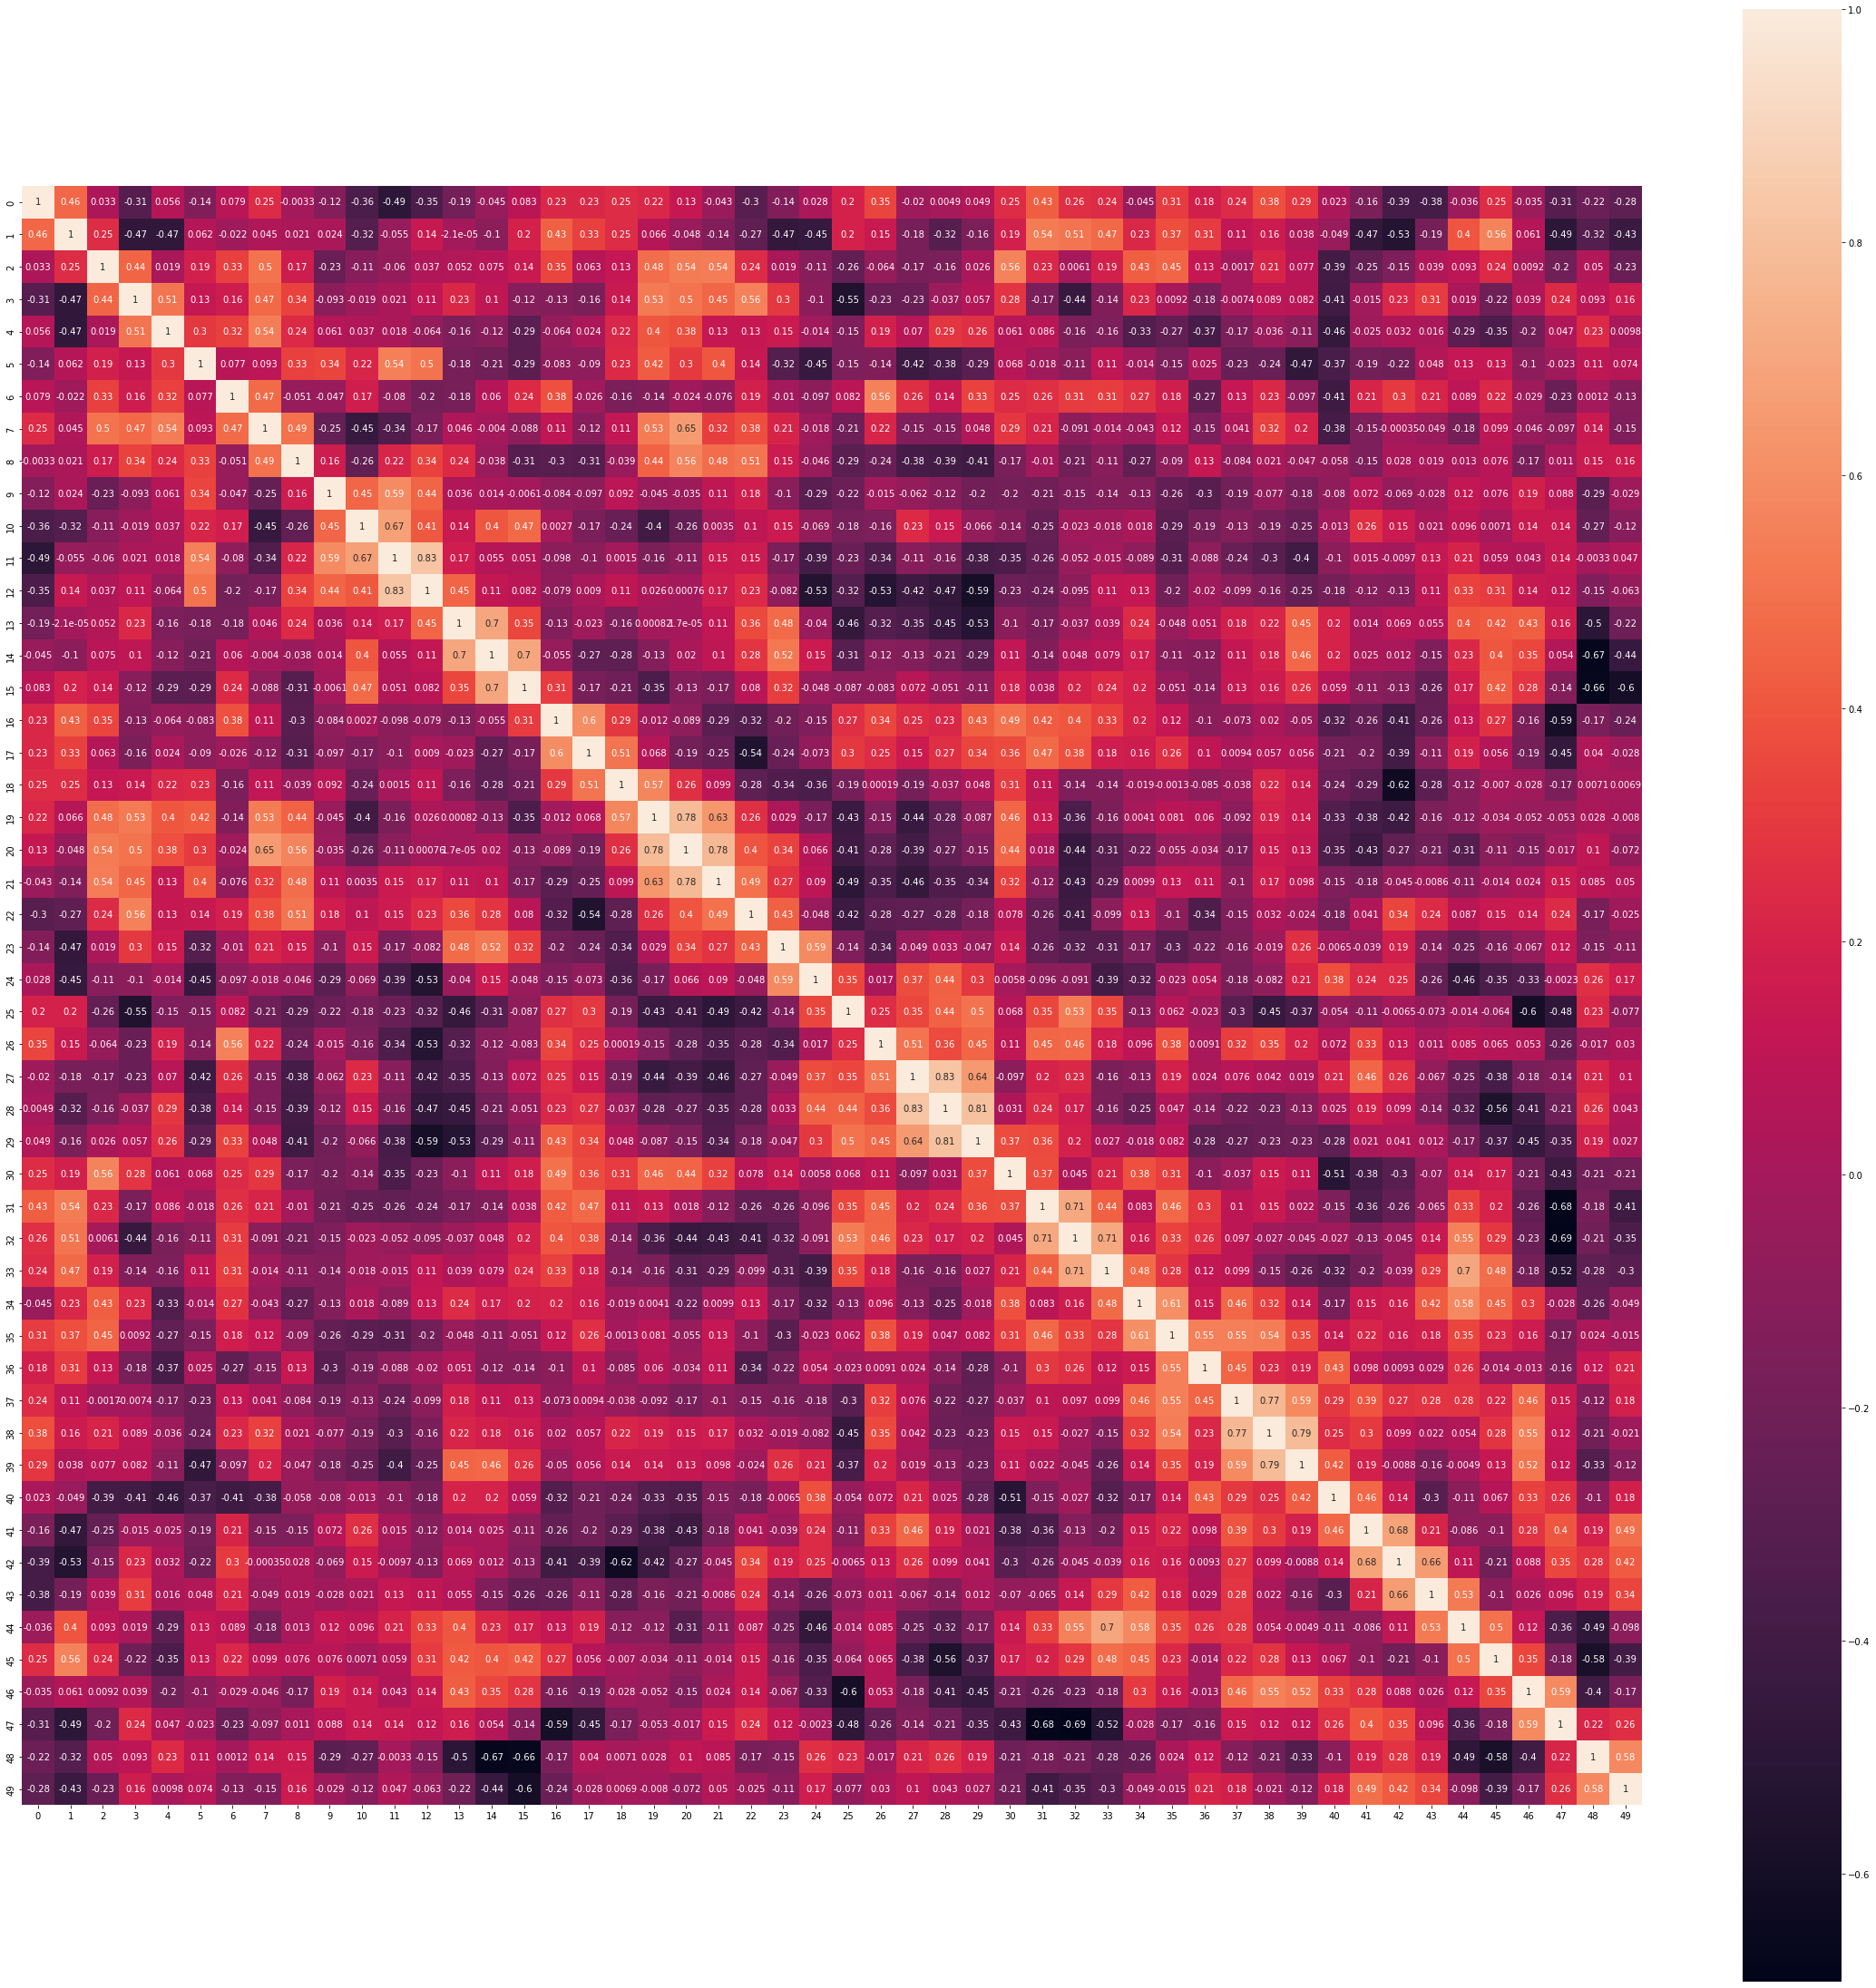

In [36]:
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(40,40)
sns.heatmap(p_val.corr(), square = True, annot = True)

## Kolmogorov–Smirnov
This test compares the underlying continuous distributions F(x) and G(x) of two independent samples. 

Burada bu test 1d array aldığı için spektogram değerleri 1d array olarak karşılaştırdım. Mantıklı mı sor ?

In [45]:
for i in range(73):
    t = np.random.randint(0,27)
    print("{}    -----------------------------------------------------------------".format(i))
    for j in range(128):
        print(stats.ks_2samp(healty[i][j], diseased[t][j]))
    print("-----------------------------------------------------------------------")

0    -----------------------------------------------------------------
KstestResult(statistic=0.9, pvalue=1.4924475501661872e-21)
KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=1.0, pvalue=1.9823306042836678e-29)
KstestResult(statistic=1.0, pvalue=1.9823306042836678e-29)
KstestResult(statistic=0.96, pvalue=9.812536491204155e-26)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.9, pvalue=1.4924475501661872e-21)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.9, pvalue=1.4924475501661872e-21)
KstestResult(statistic=0.9, pvalue=1.4924475501661872e-21)
KstestResult(statistic=0.88, pvalue=2.363041

KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.9, pvalue=1.4924475501661872e-21)
KstestResult(statistic=0.88, pvalue=2.3630419544297964e-20)
KstestResult(statistic=0.88, pvalue=2.3630419544297964e-20)
KstestResult(statistic=0.9, pvalue=1.4924475501661872e-21)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e

KstestResult(statistic=0.58, pvalue=4.047604718242212e-08)
KstestResult(statistic=0.58, pvalue=4.047604718242212e-08)
-----------------------------------------------------------------------
24    -----------------------------------------------------------------
KstestResult(statistic=0.6, pvalue=1.0624962385385807e-08)
KstestResult(statistic=0.66, pvalue=1.3182765881237494e-10)
KstestResult(statistic=0.72, pvalue=8.759312877898666e-13)
KstestResult(statistic=0.76, pvalue=2.08228179699263e-14)
KstestResult(statistic=0.82, pvalue=3.770852330233186e-17)
KstestResult(statistic=0.88, pvalue=2.3630419544297964e-20)
KstestResult(statistic=0.88, pvalue=2.3630419544297964e-20)
KstestResult(statistic=0.9, pvalue=1.4924475501661872e-21)
KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.98, pvalue=1.9823306042836677e-27)
KstestResult(statistic=0.96, pvalue=9.812536491204155e-26)
KstestResult(statistic=0.96

KstestResult(statistic=0.92, pvalue=7.773164323782225e-23)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.94, pvalue=3.205428587126691e-24)
KstestResult(statistic=0.98, pvalue=1.9823306042836677e-27)
KstestResult(statistic=0.98, pvalue=1.9823306042836677e-27)
KstestResult(statistic=0.98, pvalue=1.9823306042836677e-27)
KstestResult(statistic=0.98, pvalue=1.9823306042836677e-27)
KstestResult(statistic=0.98, pvalue=1.9823306042836677e-27)
KstestResult(statistic=1.0, pvalue=1.9823306042836678e-29)
KstestResult(statistic=0.98, pvalue=1.9823306042836677e-27)
KstestResult(statistic=0.98, pvalue=1.9823306042836677e-27)
KstestResult(statistic=0.96, pvalue=9.812536491204155e-26)
KstestResult(statistic=0.9, pvalue=1.492447550166

KstestResult(statistic=0.74, pvalue=1.409544601041165e-13)
KstestResult(statistic=0.76, pvalue=2.08228179699263e-14)
KstestResult(statistic=0.78, pvalue=2.807570962237254e-15)
KstestResult(statistic=0.76, pvalue=2.08228179699263e-14)
KstestResult(statistic=0.68, pvalue=2.6679407140599687e-11)
KstestResult(statistic=0.66, pvalue=1.3182765881237494e-10)
KstestResult(statistic=0.68, pvalue=2.6679407140599687e-11)
KstestResult(statistic=0.7, pvalue=5.022006049995235e-12)
KstestResult(statistic=0.68, pvalue=2.6679407140599687e-11)
KstestResult(statistic=0.68, pvalue=2.6679407140599687e-11)
KstestResult(statistic=0.66, pvalue=1.3182765881237494e-10)
KstestResult(statistic=0.64, pvalue=6.078719823015066e-10)
KstestResult(statistic=0.62, pvalue=2.623447502564397e-09)
KstestResult(statistic=0.56, pvalue=1.4534580579142488e-07)
KstestResult(statistic=0.56, pvalue=1.4534580579142488e-07)
KstestResult(statistic=0.58, pvalue=4.047604718242212e-08)
KstestResult(statistic=0.56, pvalue=1.4534580579142

KstestResult(statistic=0.28, pvalue=0.039194586195352224)
KstestResult(statistic=0.3, pvalue=0.02170784069014051)
KstestResult(statistic=0.3, pvalue=0.02170784069014051)
KstestResult(statistic=0.28, pvalue=0.039194586195352224)
KstestResult(statistic=0.32, pvalue=0.011511738725894704)
KstestResult(statistic=0.38, pvalue=0.0013147736033165794)
KstestResult(statistic=0.44, pvalue=9.909301386655972e-05)
KstestResult(statistic=0.5, pvalue=4.8075337049514946e-06)
KstestResult(statistic=0.52, pvalue=1.5814255608393076e-06)
KstestResult(statistic=0.52, pvalue=1.5814255608393076e-06)
KstestResult(statistic=0.54, pvalue=4.929118631187453e-07)
KstestResult(statistic=0.6, pvalue=1.0624962385385807e-08)
KstestResult(statistic=0.6, pvalue=1.0624962385385807e-08)
KstestResult(statistic=0.58, pvalue=4.047604718242212e-08)
KstestResult(statistic=0.58, pvalue=4.047604718242212e-08)
KstestResult(statistic=0.56, pvalue=1.4534580579142488e-07)
KstestResult(statistic=0.56, pvalue=1.4534580579142488e-07)
Ks

KstestResult(statistic=0.3, pvalue=0.02170784069014051)
KstestResult(statistic=0.28, pvalue=0.039194586195352224)
KstestResult(statistic=0.26, pvalue=0.06779471096995852)
KstestResult(statistic=0.26, pvalue=0.06779471096995852)
KstestResult(statistic=0.28, pvalue=0.039194586195352224)
KstestResult(statistic=0.32, pvalue=0.011511738725894704)
KstestResult(statistic=0.34, pvalue=0.005841778142694731)
KstestResult(statistic=0.3, pvalue=0.02170784069014051)
KstestResult(statistic=0.28, pvalue=0.039194586195352224)
KstestResult(statistic=0.36, pvalue=0.002834980581320342)
KstestResult(statistic=0.38, pvalue=0.0013147736033165794)
KstestResult(statistic=0.48, pvalue=1.3867885687360081e-05)
KstestResult(statistic=0.58, pvalue=4.047604718242212e-08)
KstestResult(statistic=0.64, pvalue=6.078719823015066e-10)
KstestResult(statistic=0.7, pvalue=5.022006049995235e-12)
KstestResult(statistic=0.76, pvalue=2.08228179699263e-14)
KstestResult(statistic=0.76, pvalue=2.08228179699263e-14)
KstestResult(st